In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_DIR = 'asl' 
MODEL_SAVE_PATH = 'asl_resnet50.pth'
BATCH_SIZE = 32
NUM_EPOCHS = 6  
LEARNING_RATE = 0.001
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


In [8]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import numpy as np

TRAIN_DIR = Path('./asl_data/asl_alphabet_train/asl_alphabet_train')

class_names = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
class_to_idx = {name: i for i, name in enumerate(class_names)}

print(f"Found {len(class_names)} classes.")

all_image_paths = []
all_labels = []

print("Scanning for images...")
for class_name in class_names:
    class_dir = TRAIN_DIR / class_name
    if not class_dir.exists(): continue

    images = list(class_dir.rglob("*.[jJ][pP][gG]")) + \
             list(class_dir.rglob("*.[jJ][pP][eE][gG]")) + \
             list(class_dir.rglob("*.png"))
             
    for img_path in images:
        all_image_paths.append(str(img_path))
        all_labels.append(class_to_idx[class_name])

print(f"Total images found: {len(all_image_paths)}")

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

class SimpleASLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SimpleASLDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SimpleASLDataset(val_paths, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("-" * 30)
print(f"Final Count -> Train: {len(train_dataset)} | Val: {len(val_dataset)}")
print("-" * 30)

Found 29 classes.
Scanning for images...
Total images found: 87000
------------------------------
Final Count -> Train: 69600 | Val: 17400
------------------------------


In [9]:
model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names)) 
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

/home/akshay/miniconda3/envs/alphawave/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akshay/miniconda3/envs/alphawave/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Starting training for {NUM_EPOCHS} epochs...")

try:
    for epoch in range(NUM_EPOCHS):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (LR: {current_lr})")
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc="Training", leave=True) 
        
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loop.set_postfix(loss=loss.item())

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

        scheduler.step(epoch_val_loss)

        print(f"   Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}%")
        print(f"   Val Loss:   {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}%")

        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"   >>> New best model saved! ({best_acc:.2f}%)")

except KeyboardInterrupt:
    print("\nTraining stopped manually. Saving current progress...")

print(f"\nTraining Complete. Best Validation Accuracy: {best_acc:.2f}%")

Starting training for 6 epochs...

Epoch 1/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:14<00:00,  3.54it/s, loss=0.0778]


   Train Loss: 0.5372 | Acc: 82.06%
   Val Loss:   0.0713 | Acc: 97.76%
   >>> New best model saved! (97.76%)

Epoch 2/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:18<00:00,  3.51it/s, loss=0.0475]  


   Train Loss: 0.1331 | Acc: 95.88%
   Val Loss:   0.0170 | Acc: 99.47%
   >>> New best model saved! (99.47%)

Epoch 3/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:13<00:00,  3.55it/s, loss=0.0916]  


   Train Loss: 0.0909 | Acc: 97.27%
   Val Loss:   0.0702 | Acc: 98.21%

Epoch 4/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:12<00:00,  3.55it/s, loss=0.0355]  


   Train Loss: 0.0656 | Acc: 98.06%
   Val Loss:   0.0218 | Acc: 99.33%

Epoch 5/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:11<00:00,  3.56it/s, loss=0.00832] 


   Train Loss: 0.0556 | Acc: 98.43%
   Val Loss:   0.0067 | Acc: 99.77%
   >>> New best model saved! (99.77%)

Epoch 6/6 (LR: 0.001)


Training: 100%|██████████| 2175/2175 [10:11<00:00,  3.56it/s, loss=0.0186]  


   Train Loss: 0.0480 | Acc: 98.67%
   Val Loss:   0.0181 | Acc: 99.57%

Training Complete. Best Validation Accuracy: 99.77%


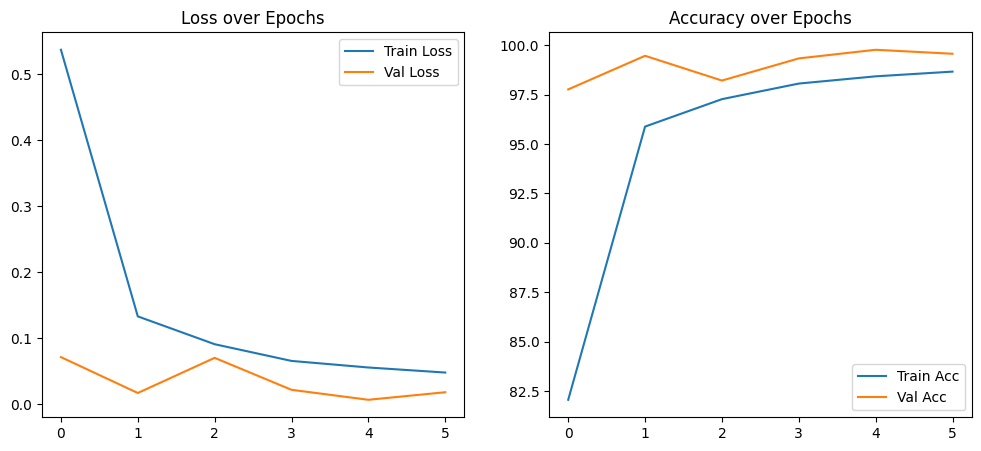

In [11]:
# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()